This notebook will guide you through the production of the plots that appear in L. de Oliveira et al.'s [_Learning Particle Physics by Example: Location-Aware Generative Adversarial Networks for Physics Synthesis_](https://arxiv.org/abs/1701.05927).

In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm, Normalize
%matplotlib inline

In this notebook, we will:
1. load 20k Pythia jet-images that were produced using Physics simulation (code available here).
2. use the trained LAGAN to generate 20k jet-images
3. evaluate the LAGAN's discriminator on both sets of images to investigate their properties (i.e.: _P(real)_, _P(signal)_)
4. investigate the results using the same visualization techniques used in the paper

### 1. Load Pythia images

Pythia is one of the standard simulation packages used in High Energy Physics (HEP) to simulate "events", i.e. the collision of protons in the Large Hadron Collider (LHC). When protons collide, their subcomponents, known as quarks and gluons, interact according to the laws of quantum chromodynamics (QCD). The equations that govern these interactions are encoded in **Pythia** and used to generate simulated collisions that closely resemble the real collision events occurring at the LHC. In HEP, we assume that the population distribution of Pythia generated events is a valid proxy for the real population distribution governed by the laws of physics.

When quarks and gluons interact at high energies, they give birth to other types of particles, that in turn decay into further particles, etc. All of these particles that move away from the collision point are captured by a particle detector, like, for example, the ATLAS detector. In this exercise, we won't model the full ATLAS detector response, but we will simply limit ourselves to discretizing the energy depositions of the streams of particles ("jets") over a grid of 25x25 cells with side 0.1 in the eta and phi coordinates.

Let's start by loading the Pythia generated jet images. You can generate them yourself using Pythia, or you can use our W'--> WZ and QCD samples used for this paper.

In [2]:
try:
    real_jets = np.load('pythia_data.npy', mmap_mode='r')
except IOError:
    # download from somewhere
    # but for now just load in mine
    #real_jets = np.load('./data/jet-images_slim_preprocessed_Mass60-100_pT250-300_R1.25_Pix25.npy', mmap_mode='r')
    real_jets = np.load('./data/jet-images_Mass60-100_pT250-300_R1.25_Pix25.npy', mmap_mode='r')

Shuffle images, then select 20k of them (in the paper, we used 200k). For quicker turnaround time, we decrease the number of jets.

In [3]:
ix = range(real_jets.shape[0])
np.random.shuffle(ix)
n_jets = 20000
real_jets = np.array(real_jets[ix[:n_jets]])

Extract the numpy array with the grayscale pixel intensities and remove all pixels with unphysically low pixel intensities (caused by numerical instabilities in the preprocessing steps). Extract the label information (i.e. boosted _W_ versus QCD jets).

In [4]:
real_images = real_jets['image']
real_images[real_images < 1e-3] = 0.0 # everything below 10^-3 is unphysical and due to instabilities in the rotation

real_labels = real_jets['signal']

### 2. Load trained generative model

In [5]:
latent_space = 200 # size of the vector z

In [6]:
gen_weights = 'gen_weights.hdf5'
disc_weights = 'disc_weights.hdf5'
if not ((os.path.isfile(gen_weights)) & (os.path.isfile(disc_weights))):
    # download from somewhere
    # but for now just load mine
    gen_weights='params_generator_epoch_034.hdf5'
    disc_weights='params_discriminator_epoch_034.hdf5'

In [7]:
%cd ./v11-lcn/ 
# TO BE REMOVED

/home/mpaganini/gan/v11-lcn


Build the generator network **G** and load the trained weights.

In [8]:
from generators import generator as build_generator
g = build_generator(latent_space, return_intermediate=False)
g.load_weights(gen_weights)

Using TensorFlow backend.


Create some random noise to be used as input to the generator, and request specific labels for the images to be produced

In [9]:
noise = np.random.normal(0, 1, (n_jets, latent_space))
sampled_labels = np.random.randint(0, 2, n_jets)

Everything is ready to generate the images!

Evaluate the generator **G** given the _noise_ and the _sampled labels_.

In [10]:
generated_images = g.predict(
    [noise, sampled_labels.reshape(-1, 1)], verbose=False, batch_size=64)

### 3. Evaluate discriminator outputs for extra info

Build the discriminator network **D** and load the trained weights.

In [11]:
from discriminators import discriminator as build_discriminator
d = build_discriminator()
d.load_weights(disc_weights)

The discriminator returns two values per image: the first corresponds to **_P(real)_**, the second to **_P(signal)_**.

Note: before training the model, we divided the pixel intensities by 100. Don't forget to do this here too before evaluating the discriminator!

In [12]:
isreal, aux_out = np.array(
    d.predict(generated_images, verbose=False, batch_size=100)
)
isreal_pythia, aux_out_pythia = np.array(
    d.predict(np.expand_dims(real_images / 100, -1), verbose=False, batch_size=100)
)

Now we have a set of 20k Pythia images, a set of 20k GAN generated images, and their respective _P(real)_ and _P(signal)_. We can use this information to visualize and analyze the GAN's performance.

### 4. Plotting functions

Create a folder called 'plots' where all the figures will be saved

In [13]:
def safe_mkdir(path):
    '''
    Safe mkdir (i.e., don't create if already exists, 
    and no violation of race conditions)
    '''
    from os import makedirs
    from errno import EEXIST
    try:
        makedirs(path)
    except OSError as exception:
        if exception.errno != EEXIST:
            raise exception

In [14]:
outdir = 'plots'
safe_mkdir(outdir)

#### a) Discriminator's Output

The plot in Fig. ?? shows the output of the discriminator network that is trying to classify real Pythia images from fake GAN generated images. In the adversarial network, the generator is learning to deceive the discriminator by generating very real-looking images. Because of this, the discriminator is almost unable to distinguish the two categories of images, and it predicts that both of them have almost equal probability of being real or fake. 

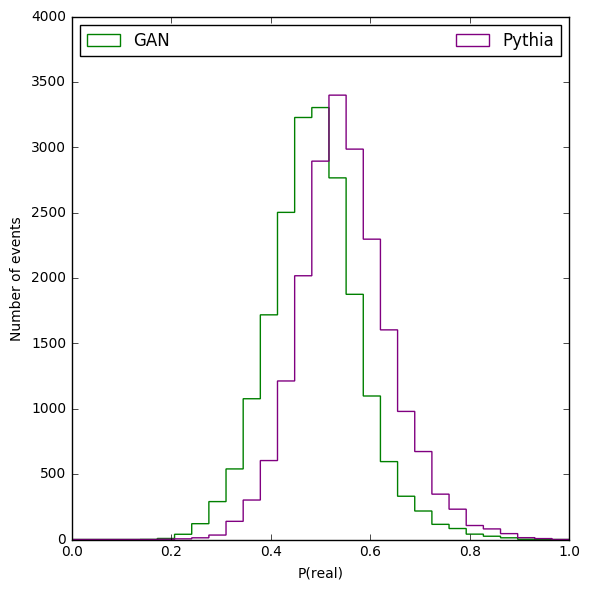

In [16]:
f = plt.figure(figsize=(6, 6))
bins = np.linspace(0, 1, 30)

_ = plt.hist(isreal, bins=bins, histtype='step', label='GAN', color='green')
_ = plt.hist(isreal_pythia, bins=bins, histtype='step', label='Pythia', color='purple')

plt.legend(ncol=2, mode='expand')
plt.xlabel('P(real)')
plt.ylabel('Number of events')
plt.ylim(ymax=4000)

plt.tight_layout()
plt.savefig(os.path.join('..', outdir, 'prob_real.pdf'))

#### a) Jet Images

First, transform the generated images by restoring the correct energy scale (previously downsized by a factor of 100), and remove the single channel dimension

In [13]:
generated_images = (generated_images) * 100
generated_images = np.squeeze(generated_images)

Here I will provide you with the functions I used to produce the plots in the paper that represent jet images or the difference among different sets of jet images. This includes Figures 1, 10, 11, 14, 15, 16, 17, 23, 24, 25, 26, 27, 28, and 29.

In [16]:
def plot_jet_image(
                    content,
                    output_name,
                    vmin=1e-6,
                    vmax=300,
                    title=''):
    '''
    Function to help you visualize a jet image on a log scale
    Args:
    -----
       content : numpy array of dimensions 25x25, first arg to imshow, content of the image
                 e.g.: generated_images.mean(axis=0) --> the average generated image
                       real_images.mean(axis=0) --> the average Pythia image
                       generated_images[aux_out == 1].mean(axis=0) --> the average generated image labeled as real by the discriminator 
                       etc...
       output_name : string, name of the output file where the plot will be saved. Note: it will be located in ../plots/
       vmin : (default = 1e-6) float, lower bound of the pixel intensity scale before saturation
       vmax : (default = 300) float, upper bound of the pixel intensity scale before saturation
       title : (default = '') string, title of the plot, to be displayed on top of the image
    Outputs:
    --------
       no function returns
       saves file in ../plots/output_name
    '''
    fig, ax = plt.subplots(figsize=(7, 6))
    extent=[-1.25, 1.25, -1.25, 1.25]
    im = ax.imshow(content, interpolation='nearest', norm=LogNorm(vmin=vmin, vmax=vmax), extent=extent)
    cbar = plt.colorbar(im, fraction=0.05, pad=0.05)
    cbar.set_label(r'Pixel $p_T$ (GeV)', y=0.85)
    plt.xlabel(r'[Transformed] Pseudorapidity $(\eta)$')
    plt.ylabel(r'[Transformed] Azimuthal Angle $(\phi)$')
    plt.title(title)
    plt.savefig(os.path.join('..', outdir, output_name))

In [17]:
def plot_diff_jet_image(
                    content,
                    output_name,
                    extr=None,
                    title='',
                    cmap=matplotlib.cm.PRGn_r):
    '''
    Function to help you visualize the difference between two sets of jet images on a linear scale
    Args:
    -----
       content : numpy array of dimensions 25x25, first arg to imshow, content of the image
                 e.g.: generated_images.mean(axis=0) - real_images.mean(axis=0) --> difference between avg generated and avg Pythia image
                       etc...
       output_name : string, name of the output file where the plot will be saved. Note: it will be located in ../plots/
       extr : (default = None) float, magnitude of the upper and lower bounds of the pixel intensity scale before saturation (symmetric around 0)
       title : (default = '') string, title of the plot, to be displayed on top of the image
       cmap : (default = matplotlib.cm.PRGn_r) matplotlib colormap, ideally white in the middle
    Outputs:
    --------
       no function returns
       saves file in ../plots/output_name
    '''
    fig, ax = plt.subplots(figsize=(6, 6))
    extent=[-1.25, 1.25, -1.25, 1.25]
    if extr == None:
        extr = max( abs(content.min()), abs(content.max()))
    im = ax.imshow(content,
                   interpolation='nearest', norm=Normalize(vmin=-extr, vmax=+extr), extent=extent,
                   cmap=cmap)
    plt.colorbar(im, fraction=0.05, pad=0.05)
    plt.xlabel(r'[Transformed] Pseudorapidity $(\eta)$')
    plt.ylabel(r'[Transformed] Azimuthal Angle $(\phi)$')
    plt.title(title)
    plt.savefig(os.path.join('..', outdir, output_name))

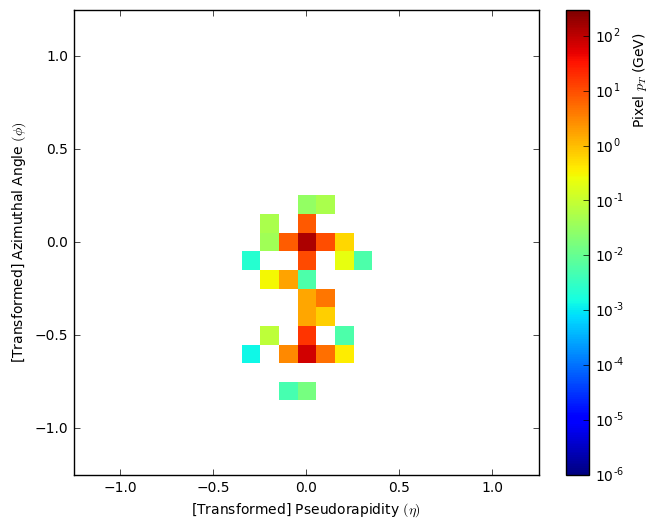

In [18]:
# -- plot the first Pythia image
plot_jet_image(
    real_images[0],
    'jet_image.pdf'
)

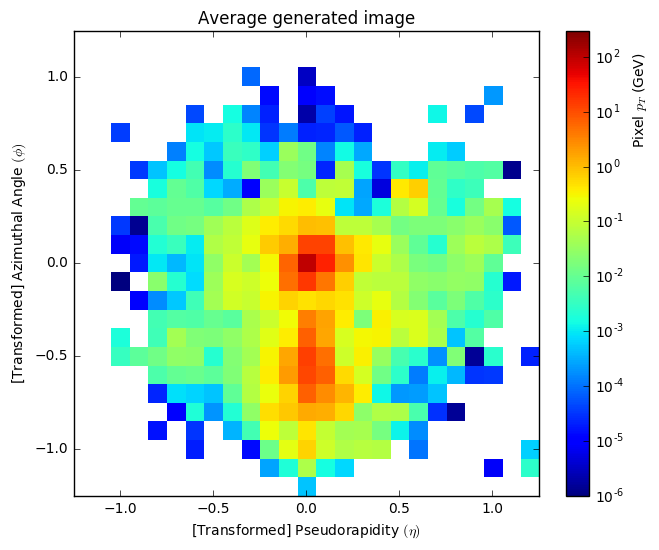

In [19]:
# -- plot the average GAN image
plot_jet_image(
    generated_images.mean(axis=0),
    'avg_gan.pdf',
    title='Average generated image'
)

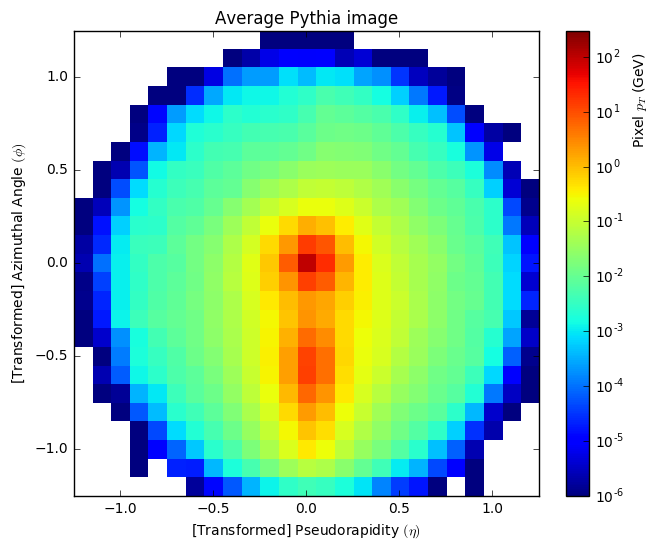

In [20]:
# -- plot the average Pythia image
plot_jet_image(
    real_images.mean(axis=0),
    'avg_pythia.pdf',
    title='Average Pythia image'
)

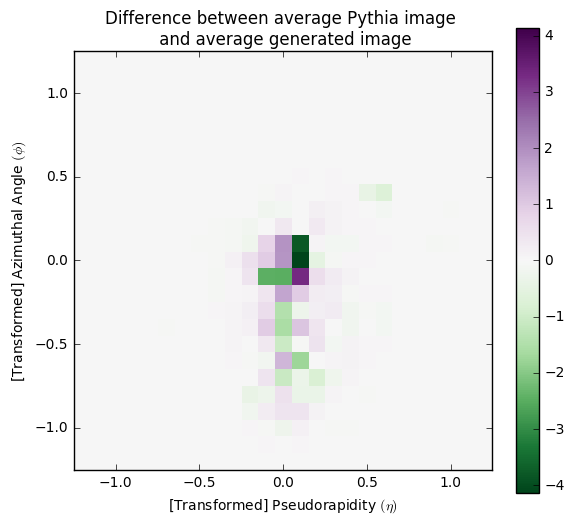

In [21]:
# -- plot the difference between the mean Pythia image and the mean GAN image
# In this case, the green pixels are more strongly activated in GAN images than in Pythia images.
# The purple pixels are more strongly activated in Pythia images than GAN images.
plot_diff_jet_image(
    real_images.mean(axis=0) - generated_images.mean(axis=0),
    'avg_pythia-avg_gan.pdf',
    title='Difference between average Pythia image \n and average generated image',
)

From this plot, we learn that the GAN tends to deposite most of the energy in the central pixel instead of properly distributing the energy across the adjacent pixels. This plot clearly shows the difference between the average look of Pythia images and GAN images, highlighting a shortcoming of our model.

In [22]:
# -- insert your favorite plot here!

#### b) Pixel Intensity Distribution

To recreate Fig. ??, we take the numpy array of Pythia images (``real_images``) and the numpy array of GAN images (``generated_images``). Both have dimensions (20000, 25, 25) $\rightarrow$ 20k images each of size 25x25 pixels.
Here we are interested in plotting the overall pixel intensity distribution across all pixels in all images, so we ``.ravel()`` the arrays into dimensions (12500000,).

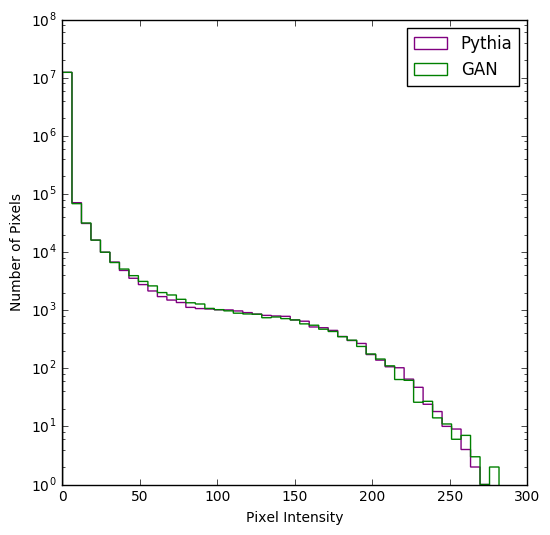

In [23]:
fig, ax = plt.subplots(figsize=(6, 6))

_, bins, _ = plt.hist(real_images.ravel(), 
           bins=np.linspace(0, 300,50), histtype='step', label='Pythia', color='purple')
_ = plt.hist(generated_images.ravel(), 
             bins=bins, histtype='step', label='GAN', color='green')

plt.xlabel('Pixel Intensity')
plt.ylabel('Number of Pixels')
plt.yscale('log')
plt.legend(loc='upper right')

plt.savefig(os.path.join('..', outdir, 'pixel_intensity.pdf'))

#### b) Jet features

Jet images are 2D representations of energy depositions from _jets_ in a layer of the calorimeter detector.

In high energy physics, we use the eta-phi coordinate system to describe the position of a particle in the detector. If we denote the direction of motion of the beam as _z_, eta and phi can be visualized as follows: <img src="https://inspirehep.net/record/1236817/files/img_cms_coordinates.png" style="width:500px;">
Source: [arXiv:1306.0858](https://arxiv.org/abs/1306.0858)

For physics reasons, in this application, we cut out the region of space very close to the beam axis ($\vert\eta\vert > 1.25$) and the region of |phi| > 1.25. We divide the remaining space in a grid with pixels of size 0.1 x 0.1

In [51]:
grid = 0.5 * (np.linspace(-1.25, 1.25, 26)[:-1] + np.linspace(-1.25, 1.25, 26)[1:])
eta = np.tile(grid, (25, 1))
phi = np.tile(grid[::-1].reshape(-1, 1), (1, 25))

From a physics standpoint, a jet possesses specific physical properties, such as mass, transverse momentum, n-subjettiness, etc., that help us identify what type of particle produced the jet. In particular, a jet that comes from the showering of a boosted W boson will look quantitatively and qualitatively different from a jet that comes from a light quark. This helps us tackle the important problem of discriminating between the two physical processes (here called _signal_ and _background_).

When a jet is represented by a discetized, pixelated jet image, these physical quantities can be calculated directly as functions of the pixel intensities. 

In [52]:
def discrete_mass(jet_image):
    '''
    Calculates the jet mass from a pixelated jet image
    Args:
    -----
        jet_image: numpy ndarray of dim (1, 25, 25)
    Returns:
    --------
        M: float, jet mass
    '''
    Px = np.sum(jet_image * np.cos(phi), axis=(1, 2))
    Py = np.sum(jet_image * np.sin(phi), axis=(1, 2))

    Pz = np.sum(jet_image * np.sinh(eta), axis=(1, 2))
    E = np.sum(jet_image * np.cosh(eta), axis=(1, 2))

    PT2 = np.square(Px) + np.square(Py)
    M2 = np.square(E) - (PT2 + np.square(Pz))
    M = np.sqrt(M2)
    return M

def discrete_pt(jet_image):
    '''
    Calculates the jet transverse momentum from a pixelated jet image
    Args:
    -----
        jet_image: numpy ndarray of dim (1, 25, 25)
    Returns:
    --------
        float, jet transverse momentum
    '''
    Px = np.sum(jet_image * np.cos(phi), axis=(1, 2))
    Py = np.sum(jet_image * np.sin(phi), axis=(1, 2))
    return np.sqrt(np.square(Px) + np.square(Py))

def dphi(phi1, phi2): 
    '''
    Calculates the difference between two angles avoiding |phi1 - phi2| > 180 degrees
    '''
    import math
    return math.acos(math.cos(abs(phi1 - phi2)))

def _tau1(jet_image):
    '''
    Calculates the normalized tau1 from a pixelated jet image
    Args:
    -----
        jet_image: numpy ndarray of dim (1, 25, 25)
    Returns:
    --------
        float, normalized jet tau1
    '''
    # find coordinate of most energetic pixel, then use formula to compute tau1
    tau1_axis_eta = eta.ravel()[np.argmax(jet_image)]
    tau1_axis_phi = phi.ravel()[np.argmax(jet_image)]
    tau1 = np.sum(jet_image * 
            np.sqrt(np.square(tau1_axis_eta - eta) + np.square([dphi(tau1_axis_phi, p) for p in phi.ravel()]).reshape(25, 25))
                 ) 
    return tau1 / np.sum(jet_image) # normalize by the total intensity


def _tau2(jet_image):
    '''
    Calculates the normalized tau2 from a pixelated jet image
    Args:
    -----
        jet_image: numpy ndarray of dim (1, 25, 25)
    Returns:
    --------
        float, normalized jet tau2
    Notes:
    ------
        slow implementation
    '''
    proto = np.array(zip(jet_image[jet_image != 0],
                         eta[jet_image != 0],
                         phi[jet_image != 0]))

    while len(proto) > 2:
        candidates = [
            (
                (i, j),
                (min(pt1, pt2) ** 2) * ((eta1 - eta2) ** 2 + (phi1 - phi2) ** 2)
            )
            for i, (pt1, eta1, phi1) in enumerate(proto)
            for j, (pt2, eta2, phi2) in enumerate(proto)
            if j > i
        ]

        index, value = zip(*candidates)
        pix1, pix2 = index[np.argmin(value)]
        if pix1 > pix2:
            # swap
            pix1, pix2 = pix2, pix1

        (pt1, eta1, phi1) = proto[pix1]
        (pt2, eta2, phi2) = proto[pix2]

        e1 = pt1 / np.cosh(eta1)
        e2 = pt2 / np.cosh(eta2)
        choice = e1 > e2

        eta_add = (eta1 if choice else eta2)
        phi_add = (phi1 if choice else phi2)
        pt_add = (e1 + e2) * np.cosh(eta_add)

        proto[pix1] = (pt_add, eta_add, phi_add)

        proto = np.delete(proto, pix2, axis=0).tolist()

    (_, eta1, phi1), (_, eta2, phi2) = proto
    np.sqrt(np.square(eta - eta1) + np.square(phi - phi1))

    grid = np.array([
        np.sqrt(np.square(eta - eta1) + np.square(phi - phi1)),
        np.sqrt(np.square(eta - eta2) + np.square(phi - phi2))
    ]).min(axis=0)

    return np.sum(jet_image * grid) / np.sum(jet_image) # normalize by the total intensity

def tau21(jet_image):
    '''
    Calculates the tau21 from a pixelated jet image using the functions above
    Args:
    -----
        jet_image: numpy ndarray of dim (1, 25, 25)
    Returns:
    --------
        float, jet tau21
    Notes:
    ------
        slow implementation
    '''
    tau1 = _tau1(jet_image)
    if tau1 <= 0:
        return 0
    else:
        tau2 = _tau2(jet_image)
        return tau2 / tau1

The jet images can be analysed to obtain the distribution of jet mass, pt and tau21 for both Pythia and GAN generated images. For visual inspection, plot the mass of GAN and Pythia jets, separating them into signal (i.e. boosted _W_) and background (i.e. QCD) jets

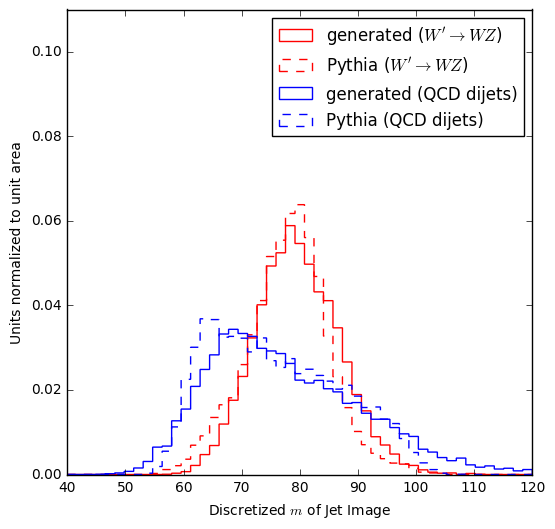

In [72]:
fig, ax = plt.subplots(figsize=(6, 6))
bins = np.linspace(40, 120, 50)
_ = plt.hist(discrete_mass(generated_images[sampled_labels == 1]), 
             bins=bins, histtype='step', label=r"generated ($W' \rightarrow WZ$)", normed=True, color='red')
_ = plt.hist(discrete_mass(real_images[real_labels == 1]), 
             bins=bins, histtype='step', label=r"Pythia ($W' \rightarrow WZ$)", normed=True, color='red', linestyle='dashed')

_ = plt.hist(discrete_mass(generated_images[sampled_labels == 0]), 
             bins=bins, histtype='step', label=r'generated (QCD dijets)', normed=True, color='blue')
_ = plt.hist(discrete_mass(real_images[real_labels == 0]), 
             bins=bins, histtype='step', label=r'Pythia (QCD dijets)', normed=True, color='blue', linestyle='dashed')

plt.xlabel(r'Discretized $m$ of Jet Image')
plt.ylabel(r'Units normalized to unit area')
plt.legend()
plt.ylim(0, 0.11)
plt.savefig(os.path.join('..', outdir, 'mass.pdf'))

Plot the transverse momentum of GAN and Pythia jets, separating them into signal (i.e. boosted W) and background (i.e. QCD) jets

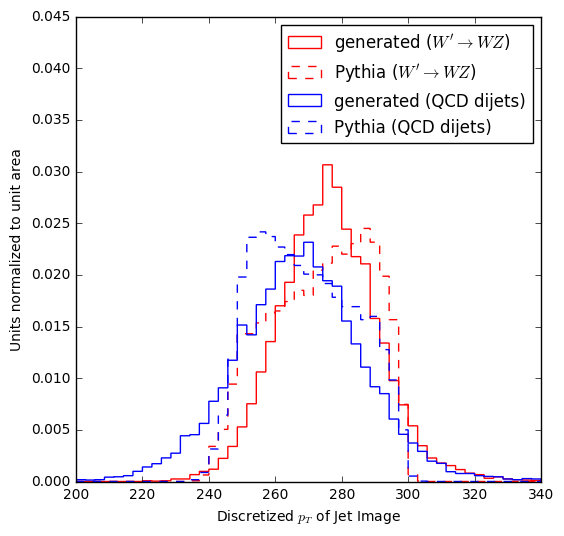

In [73]:
fig, ax = plt.subplots(figsize=(6, 6))
bins = np.linspace(200, 340, 50)
_ = plt.hist(discrete_pt(generated_images[sampled_labels == 1]), 
             bins=bins, histtype='step', label=r"generated ($W' \rightarrow WZ$)", normed=True, color='red')
_ = plt.hist(discrete_pt(real_images[real_labels == 1]), 
             bins=bins, histtype='step', label=r"Pythia ($W' \rightarrow WZ$)", normed=True, color='red', linestyle='dashed')

_ = plt.hist(discrete_pt(generated_images[sampled_labels == 0]), 
             bins=bins, histtype='step', label=r'generated (QCD dijets)', normed=True, color='blue')
_ = plt.hist(discrete_pt(real_images[real_labels == 0]), 
             bins=bins, histtype='step', label=r'Pythia (QCD dijets)', normed=True, color='blue', linestyle='dashed')
plt.xlabel(r'Discretized $p_T$ of Jet Image')
plt.ylabel(r'Units normalized to unit area')
plt.legend()
plt.ylim(0, 0.045)
plt.savefig(os.path.join('..', outdir, 'pt.pdf'))

In [ ]:
# same thing for tau21

### Discriminator outputs as functions of mass and pT

For interpretability reasons, it was interesting to us to find out if and how the net itself was internally learning and making use of the physical properties of a jet such as mass and pT to distinhuish between signal and background jets, or fake and real images.

To do so, we plot the two discriminator's outputs (_P(real)_ and _P(signal)_) as functions of the 1D quantities of interest.

In [56]:
def plot_output_vs_kin(kin, output, xlabel, ylabel, outname, nbins=30):
    '''
    Plot one output of the discriminator network vs. one of the 1D physics variables that describe jets
    Args:
    -----
        kin : numpy array, kinematic property (such as mass or pT) associated with each image. I.e.: discrete_mass(np.squeeze(generated_images))
        output : numpy array, one of the 2 outputs of the discriminator, evaluated on the same images that `kin` refers to
        xlabel : string, x-axis label that describes the meaning of `kin`
        ylabel : string, y-axis label that describes the meaning og `output`
        outname : name of the output file, to be placed in ../plots/
        nbins : (default = 30) number of bins to use to represent the distributions in a discretized way
    
    '''
    # set the colormap
    plt.set_cmap('jet')
    # draw a 2d histogram of the discriminator's output versus the kinematic variable of choice (mass, pT, etc.)
    h, binx, biny, _ = plt.hist2d(kin, output.reshape(-1,), bins=nbins)
    plt.clf() # we don't want to plot this 2D histogram, we want to normalize it per bin first
    
    # normalize the histogram such that the entries in each column add up to 1, such that the intensity
    # of each corresponds to the percentage of the jets in a given mass (or pT) bin that get assigned a p
    for i in range(nbins):
        h[i, :] = h[i, :] / float(np.sum(h[i, :]))
    # plot the normalized histogram as an image
    f, ax2 = plt.subplots(figsize=(6, 6))
    im = ax2.imshow(
        np.flipud(h.T), 
        interpolation='nearest',
        norm=LogNorm(),
        extent=[binx.min(), binx.max(), biny.min(), biny.max()],
        aspect="auto"
    )
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # add a custom colorbar
    cax = f.add_axes([0.93, 0.1, 0.03, 0.8])
    plt.colorbar(im, cax = cax)
    # save the figure as a pdf
    plt.savefig(os.path.join('..', outdir, outname), bbox_extra_artists=(cax,), bbox_inches='tight')

/home/mpaganini/.local/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in divide


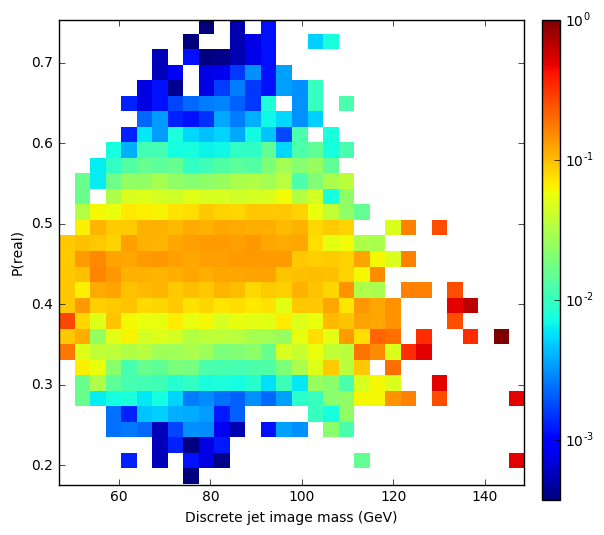

In [58]:
# -- plot P(real) for GAN generated images as a function of jet mass
plot_output_vs_kin(
    discrete_mass(np.squeeze(generated_images)),
    isreal,
    xlabel='Discrete jet image mass (GeV)',
    ylabel='P(real)',
    outname='norm_real_vs_mass_gan.pdf'
)

/home/mpaganini/.local/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in divide


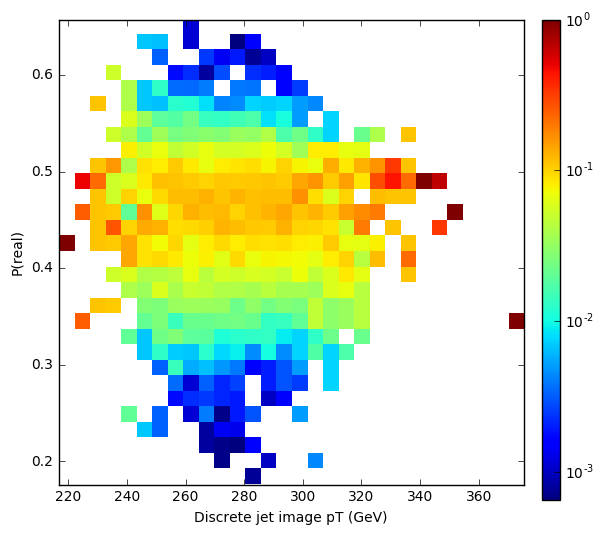

In [62]:
# -- plot P(real) for GAN generated signal (aka W boson-originated) jet images as a function of jet mass
plot_output_vs_kin(
    discrete_pt(np.squeeze(generated_images[sampled_labels == 1])),
    isreal[sampled_labels == 1],
    xlabel='Discrete jet image pT (GeV)',
    ylabel='P(real)',
    outname='norm_real_vs_pt_gan_signal.pdf'
)

Similar plots can be made for the auxiliary output of D (_P(signal)_), or for other 1D properties of jets, such as mass

#### c) Nearest GAN Neighbor Images to Given Pythia Images

We want to prove that our GAN is actually producing new, original images instead of simply learning to replicate identical images to those produce by Pythia. To do so, we pick 5 random Pythia images and find the nearest neighbor among all the generated GAN images.

In [64]:
# -- use scikit learn to find the nearest neighbors
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=1)
nn.fit(generated_images.reshape(generated_images.shape[0], -1))

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=1, p=2, radius=1.0)

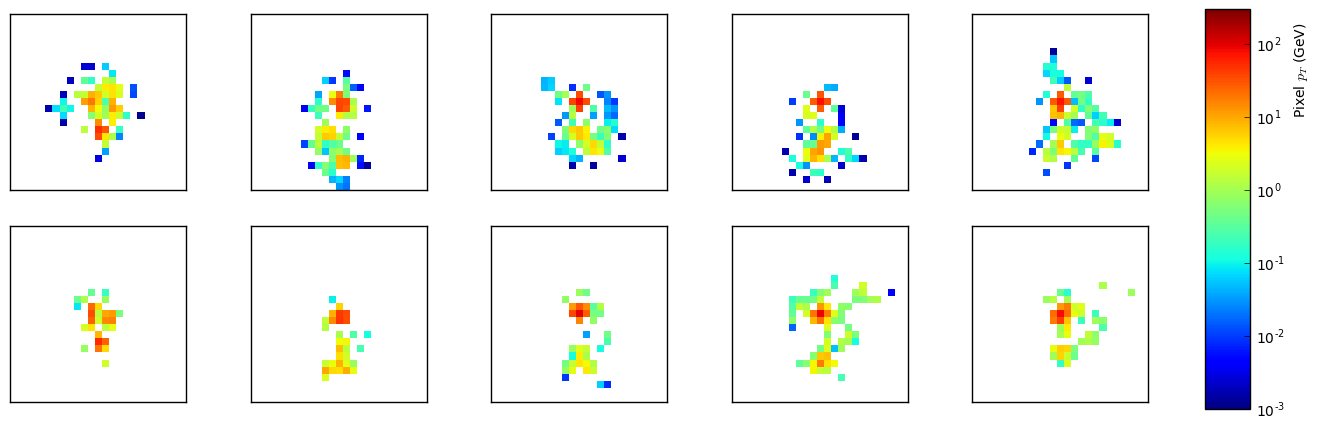

In [81]:
# plot selected Pythia jet images and show nearest
# neighbor in the set of GAN generated images

njets = 5
f, axarr = plt.subplots(2, njets, figsize=(15, 5))
jets = np.random.randint(low=0, high=real_images.shape[0], size=njets)

for i, sel in enumerate(jets):
    nbr = int(nn.kneighbors(real_images[sel].ravel().reshape(1, -1))[-1])
    def _plot_jet(n_row, images, vmin=1e-3, vmax=300):
        im = axarr[n_row, i].imshow(images,
                                    interpolation='nearest',
                                    norm=LogNorm(vmin=1e-3, vmax=300)
                                   )
        axarr[n_row, i].tick_params(axis='both', which='both', bottom='off', top='off',
                                left='off', right='off', labelbottom='off',
                                labelleft='off')
    _ = [_plot_jet(*content) for content in enumerate([real_images[sel], generated_images[nbr]])]

cax = f.add_axes([0.93, 0.11, 0.03, 0.8])
cb = f.colorbar(im, cax=cax)
cb.set_label(r'Pixel $p_T$ (GeV)', y=0.85)
plt.savefig(os.path.join('..', outdir, 'nearest_neighbors.pdf'), bbox_extra_artists=(cax,), bbox_inches='tight')

Luckily, our GAN didn't just memorize a set of Pythia images! It is actually generating its own kind of images that, although very similar to the ones in the original set, possess unique properties and explore multiple subspaces. 

#### d) Visualize what's being learned by the generator

We were curious to look inside our GAN and see if we could learn something about what the GAN itself was learning. How did it develop a notion of what it means for a jet image to be originated from a boosted W boson coming from the decay of a W', as opposed to being originated from a common QCD event? How did the representation change across layers?

To figure this out, we probed the generator right after the various hidden locally-connected layers.

The idea is to pass specific requests to the generator in the form of auxiliary labels (here called *sampled_labels*). The generator will generate images that correspond to the given labels. Recall: 1 = signal = W boson jet; 0 = background = QCD jet

In [20]:
# -- first we need to find the name of the layers that we want to probe for intermediate outputs
# -- we do so by looking at the names of the layers and matching them with the LAGAN structure in the paper
[layer.name for layer in g.layers]

['input_2', 'embedding_1', 'input_1', 'flatten_1', 'merge_1', 'sequential_1']

Because of the way the generator was built, the main part of the network is encapsulated by 'sequential_1', while the first few layers represent the hadamard product between the latent vector _z_ and the learned embedding of the requested label. To find the name of the layers we want to probe, then, we have to dig one step deeper.

In [22]:
# -- list the name of the layers in 'sequential_1'
[layer.name for layer in g.layers[-1].layers]

['dense_1',
 'reshape_1',
 'convolution2d_1',
 'leakyrelu_1',
 'batchnormalization_1',
 'upsampling2d_1',
 'zeropadding2d_1',
 'locallyconnected2d_1',
 'leakyrelu_2',
 'batchnormalization_2',
 'upsampling2d_2',
 'locallyconnected2d_2',
 'leakyrelu_3',
 'locallyconnected2d_3']

In [23]:
# -- we can easily identify the locally connected layers, and probe the network right after their transformed outputs
desired_stages = ['batchnormalization_2', 'leakyrelu_3']
# -- you could have chosen any intermediate layer to probe the network
# -- we chose to look at the output of the 1st LC layer after the activation and the batch normalization, but this is
# not necessary

Now, ideally you would provide the latent vector _z_ and the requested label as inputs, and simply ask for the outputs at the two *desired_stages* specified above. However, this doesn't quite work, probably because of the fact that the generator contains a "sub-model" called 'sequential_1' (as seen above), which complicates the relation between layers such as 'input_1' and 'input_2' and the outputs defined in *desired_stages*. Here's the error:

In [24]:
from keras.models import Model
image_stages = Model(
    input=g.get_input_at(0),
    output=[g.layers[-1].get_layer(l).output for l in desired_stages]
)
image_stages.predict([noise, sampled_labels.reshape(-1, 1)], verbose=False, batch_size=64)

RuntimeError: Graph disconnected: cannot obtain value for tensor Tensor("dense_input_1:0", shape=(?, 200), dtype=float32) at layer "dense_input_1". The following previous layers were accessed without issue: []

Okay, let's try to do this step by step then. Let's first evaluate the first few steps (inputs, embedding, merge), then feed their output into 'sequential_1' to get the intermediate results at the *desired_stages*.

In [28]:
# -- the first step corresponds to calculating the embedding of the label and taking an element-wise product
# with the latent vector z, in order to obtain a version of z that is conditional on the requested label
first_half = Model(
    input=g.get_input_at(0),
    output=g.get_layer('merge_1').output
)
conditional_z = first_half.predict([noise, sampled_labels.reshape(-1, 1)], verbose=False, batch_size=64)

Now we turn the output of the first half of the generator into the input to the second half, called 'sequential_1':

In [31]:
sequential_1 = g.layers[-1]
image_stages = Model(
    input=sequential_1.get_input_at(0),
    output=[sequential_1.get_layer(l).output for l in desired_stages]
)
probes = image_stages.predict(conditional_z, verbose=False, batch_size=64)

Finally, let's visualize what the images look like at the two intermediate layers we probed.

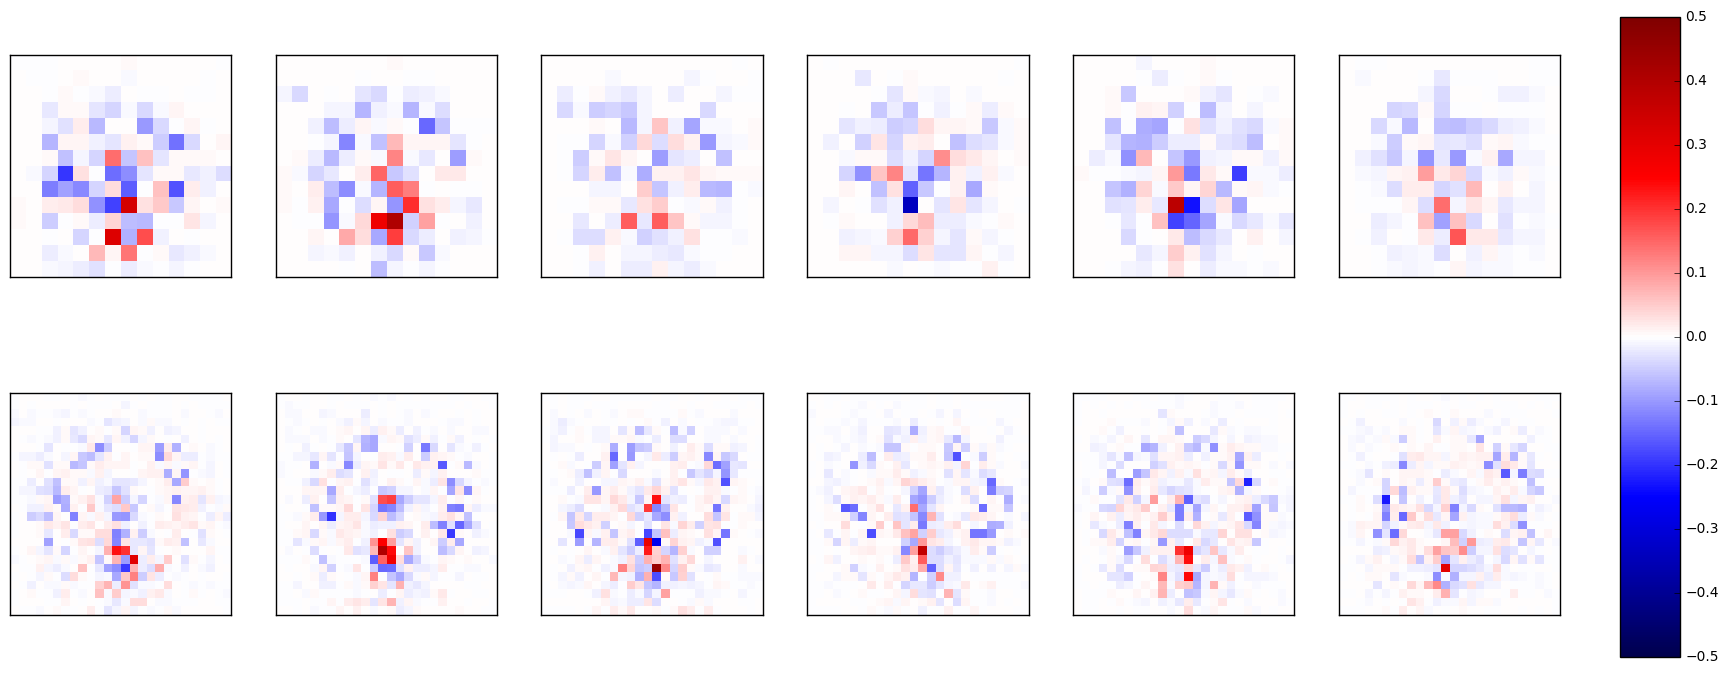

In [40]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(20,8))
gs = gridspec.GridSpec(2, 6)
ax1 = plt.subplot(gs[0, :])

def plot_probe(n, probe):
    '''
    Args:
    -----
        n : int, layer index in the list of *desired_stages*. 
            Used to make the plot pretty by reserving one row of images per layer
        probe : output of the intermediate layer we are probing.
                These will be N images, where N is the depth dimension of the intermediate layer
    Returns:
    --------
        im : the matplotlib image object
    '''
    extent=[-1.25, 1.25, -1.25, 1.25]
    for i in range(probe.shape[-1]):
        ax=plt.subplot(gs[n, i%6])
        im = ax.imshow(
            probe[:, :, :, i][sampled_labels == 1].mean(axis=0) - probe[:, :, :, i][sampled_labels == 0].mean(axis=0),
            interpolation='nearest',
            norm=Normalize(vmin=-0.5, vmax=0.5),
            extent=extent,
            cmap=matplotlib.cm.seismic
        )
        ax.tick_params(
            axis='both',       # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            left='off',
            right='off',
            labelbottom='off',
            labelleft='off')
    return im
    
im = [plot_probe(n, probe) for n, probe in enumerate(probes)]
    
cax = fig.add_axes([0.93, 0.11, 0.03, 0.8])
fig.colorbar(im[0], cax=cax)

plt.savefig(os.path.join('..', outdir, 'lc_intermediate_signal-bkg.pdf'))

The first row of images represents the output after the first intermediate layer ('batchnormalization_2') while the second row represents the output after the second intermediate layer ('leakyrelu_3').

In this plot, we wanted to visualize the difference in average activation intensities of intermediate image representations between signal images (where the requested label was a 1) and background images (where the requested label was a 0). Blue pixels are more strongly activated in background images, and red pixels are more strongly activated for signal images. This is to be compared to the final output images, shown in the paper in Figure ??

Notice how the main characteristics that help us differentiate W boson from QCD initiated jet images are learned by the network very early on -- for example, we know that a larger, more spread out radiation pattern corresponds to more background like images, while intense energy depositions around the location of the subleading subjet is typical of W jets.

### Visualize what's being learned by the discriminator

We can follow a similar logic to inspect the internal behavior of the discriminator network.

In [42]:
first_conv_layer = d.layers[1].layers[1]
W, _ = first_conv_layer.get_weights() # returns W, bias

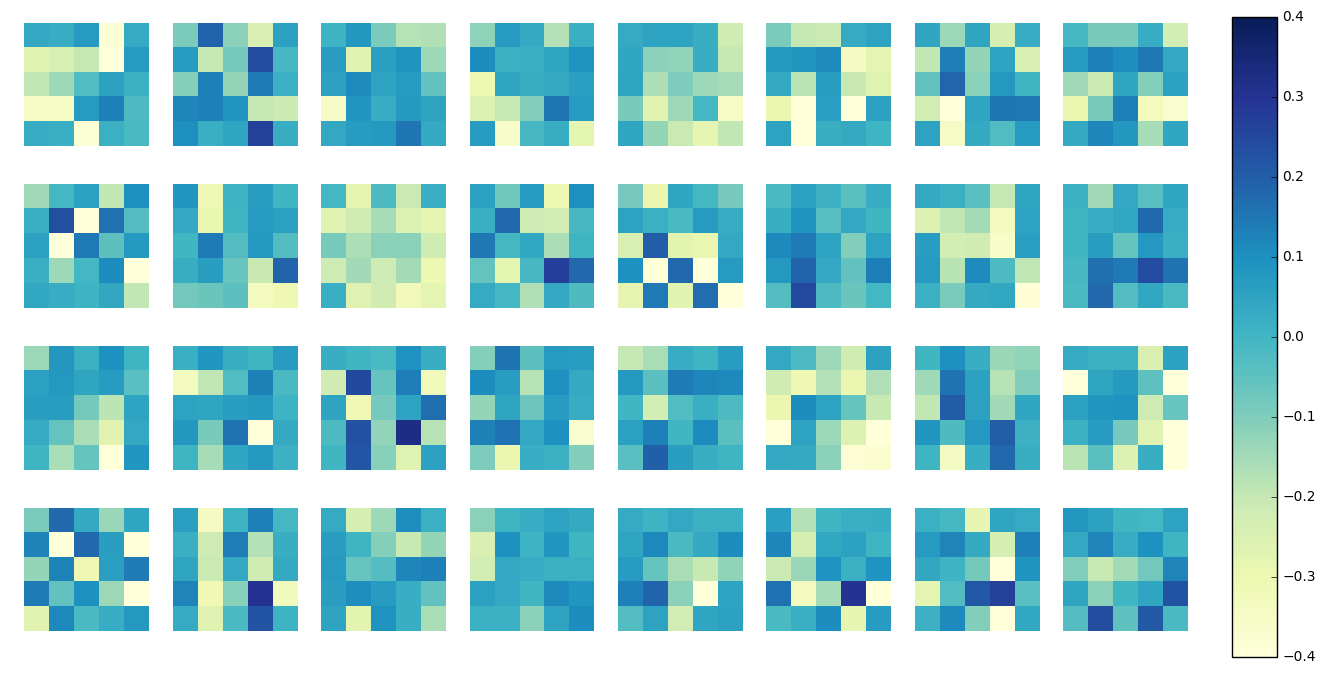

In [43]:
f, axarr = plt.subplots(4, 8, figsize=(15, 8))
plt.set_cmap('YlGnBu')
for i in range(W.shape[-1]):
    im = axarr[i/8, i%8].imshow(
        np.squeeze(W)[:, :, i],
        interpolation='nearest',
        norm=Normalize(vmin=-0.4, vmax=0.4)
    )
    axarr[i/8, i%8].axis('off')

# Make an axis for the colorbar on the right side
cax = f.add_axes([0.93, 0.1, 0.03, 0.8])
fig.colorbar(im, cax=cax)
plt.savefig(os.path.join('..', outdir, 'conv_filters.pdf'))

In [47]:
def plot_discriminator(content, outname, cmap='PRGn_r', vmin=-10, vmax=10):
    '''
    '''
    from scipy.signal import convolve2d
    f, axarr = plt.subplots(4, 8, figsize=(15, 8))
    plt.set_cmap(cmap)

    for i in range(W.shape[-1]):
        im = axarr[i/8, i%8].imshow(
            convolve2d(
                content,
                np.squeeze(W)[:, :, i],
                mode='same'
            ),
            interpolation='nearest',
            norm=Normalize(vmin=vmin, vmax=vmax)
        )
        axarr[i/8, i%8].tick_params(
            axis='both',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            left='off',
            right='off',
            labelbottom='off',
            labelleft='off')

    # Make an axis for the colorbar on the right side
    cax = f.add_axes([0.93, 0.11, 0.03, 0.8])
    f.colorbar(im, cax=cax)
    plt.savefig(os.path.join('..', outdir, outname))

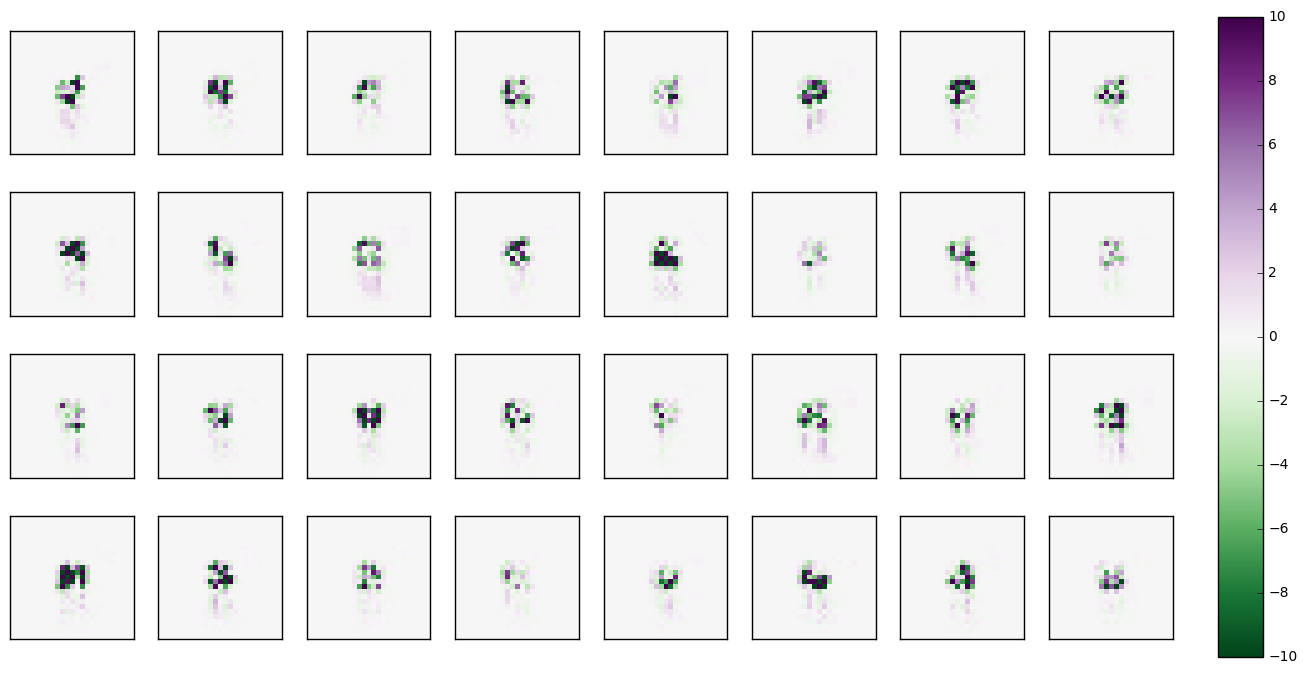

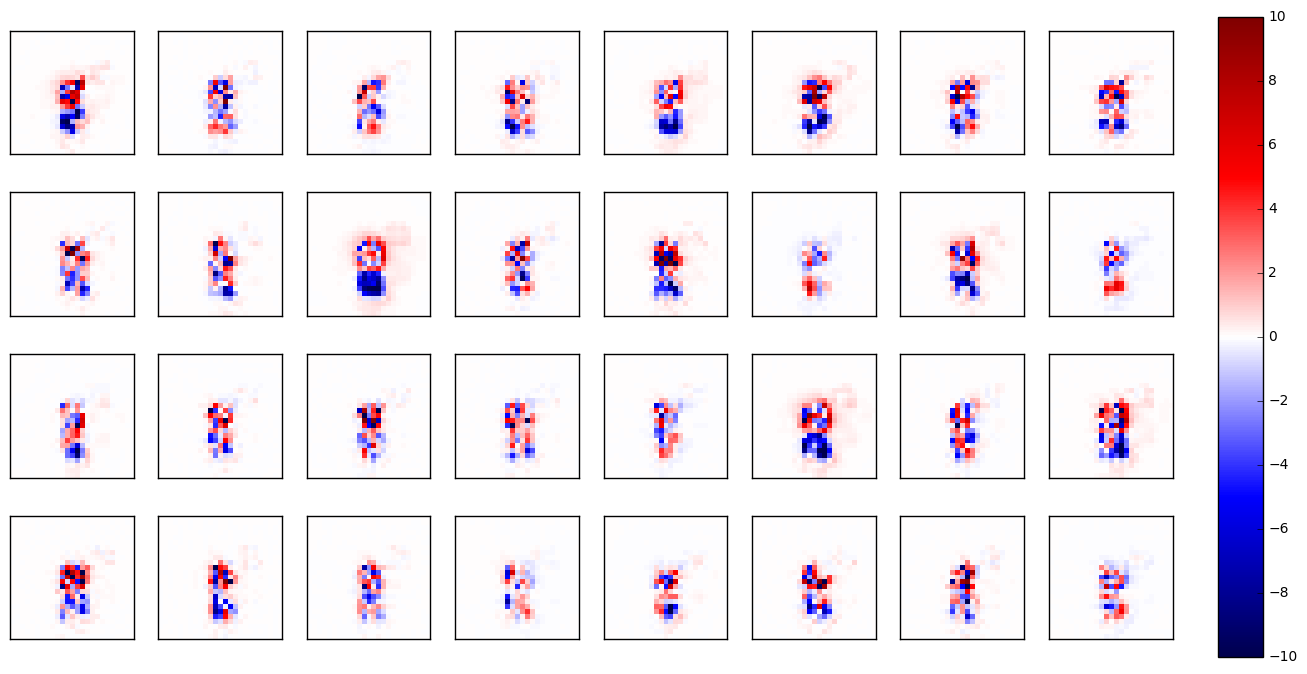

In [48]:
plot_discriminator(
    real_images.mean(axis=0) - np.squeeze(generated_images.mean(axis=0)), 
    'activation_filters_pythia-gan.pdf'
) # Pythia - GAN    

plot_discriminator(
    np.squeeze(generated_images[sampled_labels == 1].mean(axis=0) - generated_images[sampled_labels == 0].mean(axis=0)),
    'activation_filters_gan_signal-gan_bkg.pdf',
    cmap='seismic'
) # signal - bkg

Finally, we look at the correlation between the average image and the discriminator's outputs. This can be done in many ways, but here's the original method I used (based on ``pandas``):

In [51]:
def get_correlations(images, disc_output):
    '''
    '''
    import pandas as pd
    # -- find the total number of pixels per image, here 25 x 25
    n_pixels = np.prod(generated_images.shape[1:3])
    
    # -- add the pixels as columns to a dataframe
    df = pd.DataFrame({i : np.squeeze(images).reshape(-1, n_pixels)[:, i] for i in range(n_pixels)})
    # -- add a column to the end of the dataframe for the discriminator's output
    df['disc_output'] = disc_output
    # -- pandas offers an easy solution to calculate correlations 
    # (even though it's slow because it also calculates the correlation between each pixel and every other pixel)
    correlations = df.corr().values[:-1, -1]
    return correlations

def plot_correlations(correlations, extent, outname, title='', img_dim=(25, 25), cmap=plt.cm.seismic):

    max_mag = max(
        abs(np.min(correlations[np.isfinite(correlations)])),
        abs(np.max(correlations[np.isfinite(correlations)])),
    ) # highest correlation value (abs value), to make the plot look nice and on a reasonable scale

    f, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(
        correlations.reshape(img_dim),
        interpolation='nearest',
        norm=Normalize(vmin=-max_mag, vmax=max_mag),
        extent=extent,
        cmap=cmap
    )
    
    plt.colorbar(im, fraction=0.05, pad=0.05)
    plt.xlabel(r'[Transformed] Pseudorapidity $(\eta)$')
    plt.ylabel(r'[Transformed] Azimuthal Angle $(\phi)$')
    plt.title(title)
    plt.savefig(os.path.join('..', outdir, outname))

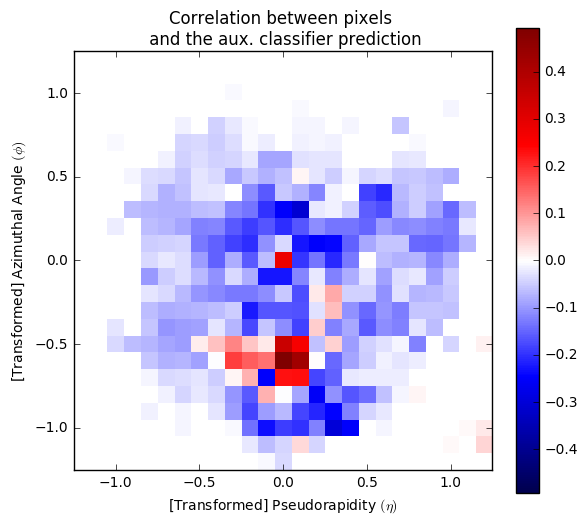

In [53]:
plot_correlations(
    get_correlations(generated_images, aux_out),
    extent=[-1.25, 1.25, -1.25, 1.25],
    outname='correlation_pixel_aux.pdf',
    title='Correlation between pixels \n and the aux. classifier prediction'
)

In [42]:
# correlation between the pixels of a GAN image and the output of the D that tells us if an image looks more like signal or bkg

625

#### Confusion Matrices

We use confusion matrices in Fig. ?? to show that the GAN generated images appear to be easier to classify into signal (_W_ boson) and background (QCD) than the original Pythia images. Here is how you can recreate those plots:

In [30]:
def plot_confusion_matrix(x, y, xticks, yticks, outname, title='', cmap=plt.cm.Blues):
    '''
    Args:
    -----
        x : numpy array of predicted labels
        y : numpy array of true labels
        xticks : list of strings with the labels to assign to the ticks on the x-axis 
        yticks : list of strings with the labels to assign to the ticks on the x-axis 
        outname : name of the output file, to be placed in ../plots/
        title : (default='') string, title of the plot
        cmap : (default=plt.cm.Blues) matplotlib colormap
    Returns:
    --------
        cm_normalized: numpy array with the numerical entries corresponding to the cells of the 
                       normalized confusion matrix
    Outputs:
    --------
        Saves a pdf as ../plots/<outname>
    '''
    # Use scikit-learn to build the confusion matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y, x)
    # Normalize it by row (i.e each row of cells will add up to unity)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    f, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(cm_normalized, interpolation='nearest', cmap=cmap, norm=Normalize(vmin=0, vmax=1))
    plt.title(title)
    plt.colorbar(im, fraction=0.05, pad=0.05)
    tick_marks = np.arange(len(xticks))
    plt.xticks(tick_marks, xticks)
    plt.yticks(tick_marks, yticks)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(os.path.join('..', outdir, outname))
    return cm_normalized

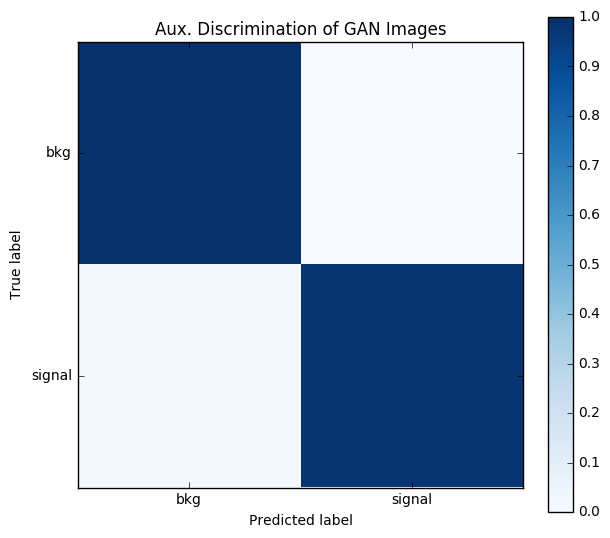

In [32]:
# -- plot the auxiliary discrimination confusion matrix for GAN images
cm_entries = plot_confusion_matrix(
    (aux_out > 0.5),
    sampled_labels,
    xticks=['bkg', 'signal'], yticks=['bkg', 'signal'],
    outname='confusion_true_predicted_signal_bkg_gan.pdf',
    title='Aux. Discrimination of GAN Images',
)

In [33]:
# -- visualize the numerical entries in the confusion matrix above
print cm_entries

[[ 0.99739034  0.00260966]
 [ 0.01604065  0.98395935]]


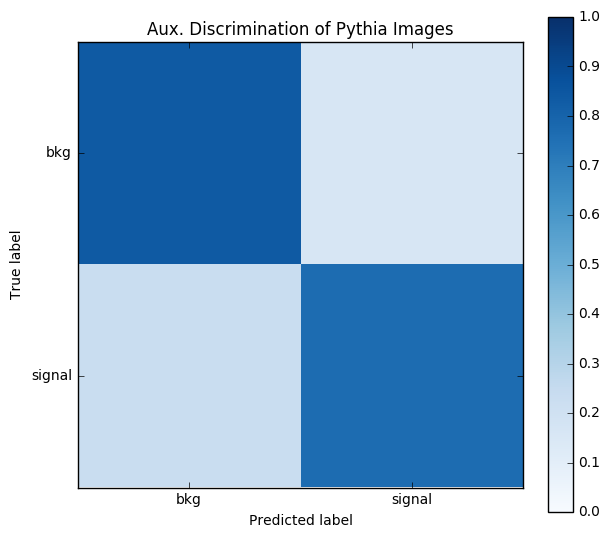

In [34]:
# -- plot the auxiliary discrimination confusion matrix for Pythia images
cm_entries = plot_confusion_matrix(
    (aux_out_pythia > 0.5),
    real_labels,
    xticks=['bkg', 'signal'], yticks=['bkg', 'signal'],
    outname='confusion_true_predicted_signal_bkg_pythia.pdf',
    title='Aux. Discrimination of Pythia Images',
)

Other confusion plots are present in Appendix A but show something slightly different. In Fig. ??, in fact, we use a confusion plot to investigate the relation between the primary output of the discriminator _P(real)_ and the physical process that generated the image (_W_ vs QCD). 

Here, for example, is how to make the first plot in Fig. ?? using the same function as above:

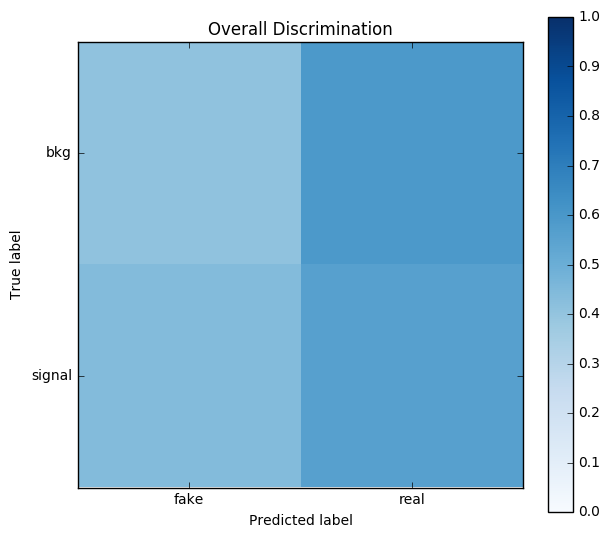

In [35]:
cm_entries = plot_confusion_matrix(
    np.concatenate((isreal_pythia >= 0.5, isreal >= 0.5)),
    np.concatenate((real_labels, sampled_labels), axis=-1),
    xticks=['fake', 'real'], yticks=['bkg', 'signal'],
    outname='confusion_predicted_real_fake.pdf',
    title='Overall Discrimination'
)